In [1]:
import numpy as np 
import pymc3 as pm
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt 
import scipy.stats as stats

plt.style.use('ggplot')

%matplotlib inline
%load_ext watermark

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Grid Approximation

One of the simplest conditioning techniques is grid approxi-
mation. While most parameters are continuous, capable of taking on an infinite number of
values, it turns out that we can achieve an excellent approximation of the continuous pos-
terior distribution by considering only a finite grid of parameter values. At any particular
value of a parameter, $p'$ , it’s a simple matter to compute the posterior probability: just multiply the prior probability of $p'$ by the likelihood at $p'$ . Repeating this procedure for each value in the grid generates an approximate picture of the exact posterior distribution.

In [2]:
def grid_approx(prior_fn, lh_fn, grid_length = 20):
    p_grid = np.linspace(0, 1, grid_length)
    prior = prior_fn(p_grid)
    likelihood = lh_fn(p_grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / np.sum(unstd_posterior)
    return p_grid, prior, posterior

In [3]:
def plotgrid(grid, prior, posterior):
    fig = plt.figure(figsize=(21, 7))
    ax1 = fig.add_subplot(121)
    ax1.set_ylabel('prior')
    ax1.set_xlabel('grid')
    ax1.set_title('Prior probability')
    ax1.plot(grid, prior, '-o')
    ax2 = fig.add_subplot(122)
    ax2.set_ylabel('Posterior')
    ax2.set_xlabel('grid')
    ax2.set_title('Posterior probability')
    ax2.plot(grid, posterior, '-o')

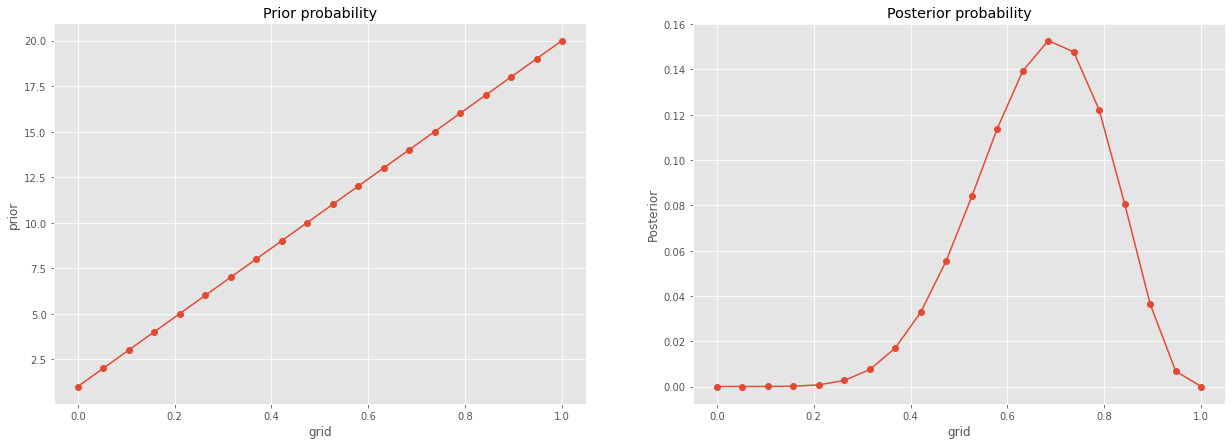

In [4]:
priorfn = lambda grid: np.arange(1, len(grid) + 1)
lhfn = lambda grid: stats.binom.pmf(6, 9, grid)
grid, prior, posterior = grid_approx(priorfn, lhfn, 20)
plotgrid(grid, prior, posterior)

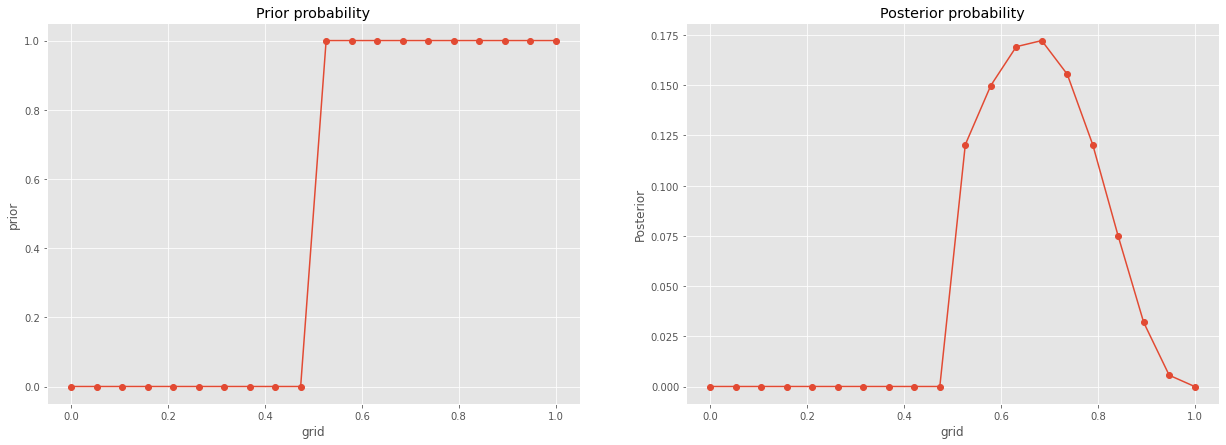

In [5]:
priorfn = lambda grid: np.where(grid < 0.5, 0, 1)
grid, prior, posterior = grid_approx(priorfn, lhfn, 20)
plotgrid(grid, prior, posterior)

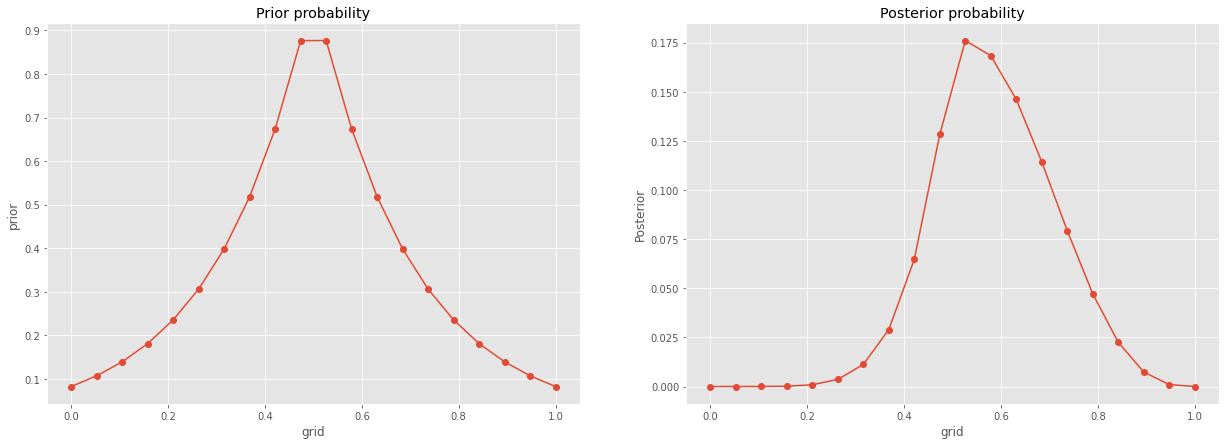

In [6]:
priorfn = lambda grid: np.exp(-5 * np.abs(grid - 0.5))
grid, prior, posterior = grid_approx(priorfn, lhfn, 20)
plotgrid(grid, prior, posterior)

### Quadratic Approximation

Under quite general conditions, the region near the peak of the posterior distribution will be nearly Gaussian - or "normal" in shape. This means the posterior distribution can be usefully approximated by a Gaussian distribution. 

Computionally, Quadratic approximation is very inexpensive. The procedure

(1) Find the posterior mode. The algorithm "climbs" the posterior distribution as if it were a mountain. The golem doesn’t know where the peak is, but it does know the slope under its feet. There are many well-developed optimization procedures, most of
them more clever than simple hill climbing. But all of them try to find peaks.

(2) Once you find the peak of the posterior, you must estimate the curvature near the peak. This curvature is sufficient to compute a quadratic approximation of the entire posterior distribution. In some cases, these calculations can be done analytically, but usually your computer uses some numerical technique instead.

In [7]:
def QPBinom(W, L):
    data = np.repeat((0,1),(L, W))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)
        w = pm.Binomial("w", n = len(data), p = p, observed=data.sum())
        mean_q = pm.find_MAP()
        std_q = ((1 / pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
    return mean_q, std_q

In [8]:
# Win = 6, Loss = 3, Total: 9
W, L = 6, 3
mean_q, std_q = QPBinom(W, L)
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1-prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print('   Mean  Sd    5.5%  94.5% \np  {:.2}, {:.2}, {:.2}, {:.2}'.format(mean_q["p"], std_q[0], pi[0], pi[1]))


   Mean  Sd    5.5%  94.5% 
p  0.67, 0.16, 0.42, 0.92


As we know the exact distribution, we could plot the exact distribution and the approximate distribution to see how exact the value is

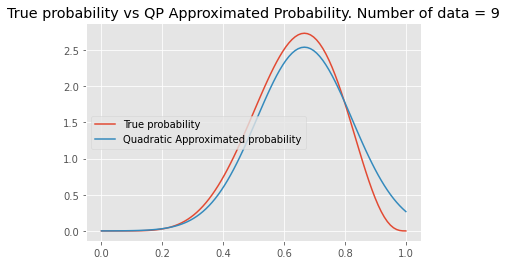

In [9]:
x = np.linspace(0, 1, 100)
true_prob = stats.beta.pdf(x, W + 1, L + 1)
approx_prob = stats.norm.pdf(x, mean_q["p"], std_q)

plt.plot(x, true_prob, label="True probability")
plt.plot(x, approx_prob, label="Quadratic Approximated probability")
plt.title(f"True probability vs QP Approximated Probability. Number of data = {W + L}")
plt.legend(loc=0);

In [10]:
x = np.linspace(0, 1, 100)
WL = [(6,3), (12, 6), (24, 12)]
results = []
for W, L in WL:
    mean_q, std_q = QPBinom(W, L)
    true_prob = stats.beta.pdf(x, W + 1, L + 1)
    approx_prob = stats.norm.pdf(x, mean_q["p"], std_q)
    results.append((W + L, true_prob, approx_prob))

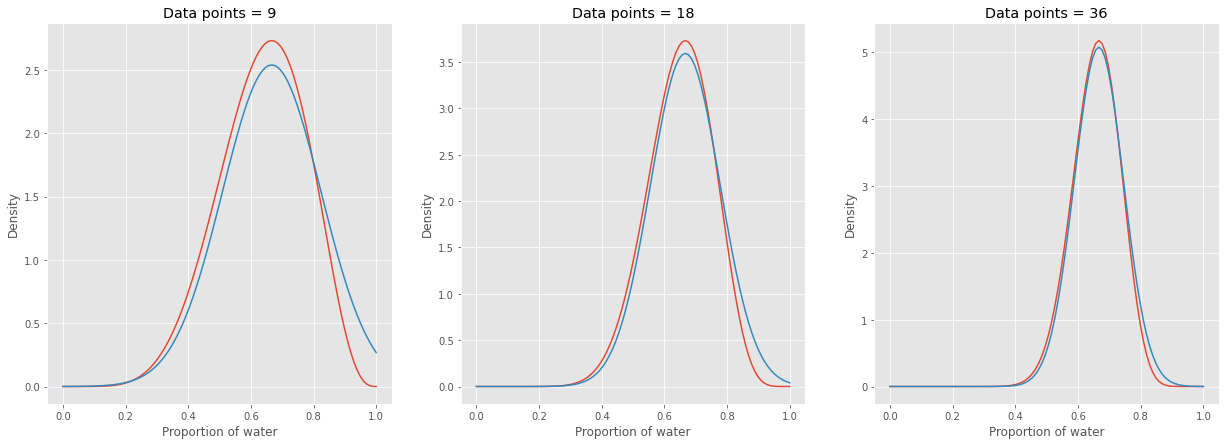

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
for idx, r in enumerate(results):
    ax[idx].plot(x, r[1], label="True probability")
    ax[idx].plot(x, r[2], label="Quadratic Approximated probability")
    ax[idx].set(title=f"Data points = {r[0]}", xlabel="Proportion of water", ylabel="Density")

### Markov Chain Monte Carlo

Multilevel models do not always allow us to write down a single, unified function for the posterior distribution. This means that the function to maximize (when finding MAP) is not known, but must be computed in pieces.

MCMC is the most counterintuitive model fitting techniques and is a family of conditioning engins capable of handling highly complex models. MCMC is largely responsible for the insurgence of Bayesian data analysis that began in the 1990s. MCMC is in the rise of affordable computing power. 

For example the Metropolis Algorithm 

In [12]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W, L = 6, 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i-1], 0.1).rvs()
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, W+L, p=p[i-1])
    q1 = stats.binom.pmf(W, W+L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i-1]

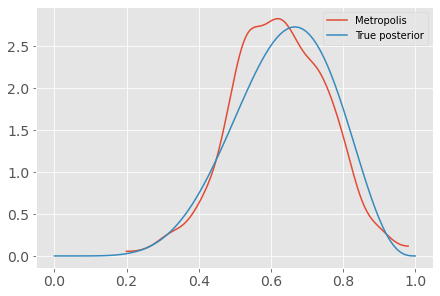

In [13]:
az.plot_kde(p, label="Metropolis")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W+1, L+1), "C1", label="True posterior")
plt.legend();

### Some computation for the Summary / Practice in the book

**2M1**. Recall the globe tossing model from the chapter. Compute and plot the grid approximate
posterior distribution for each of the following sets of observations. In each case, assume a uniform
prior for p.

1. W, W, W
2. W, W, W, L
3. L, W, W, L, W, W, W

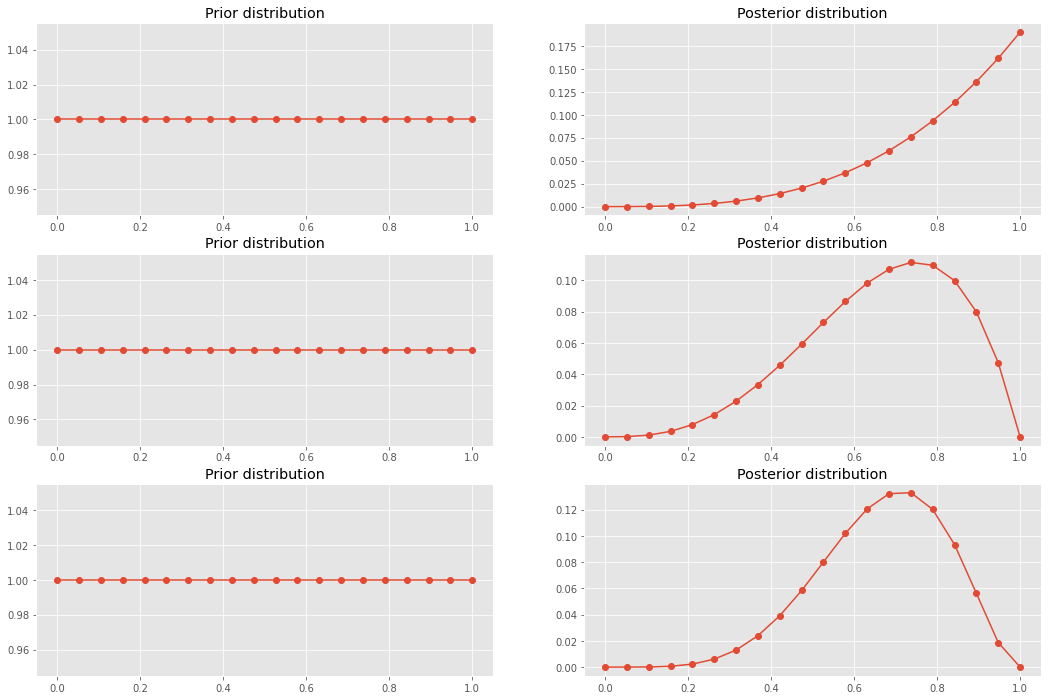

In [46]:
priorfn = lambda grid: stats.uniform.pdf(grid)
WL = [(3,3), (3,4), (5,7)]
results = []
for idx, result in enumerate(WL):
    lhfn = lambda grid: stats.binom.pmf(result[0], result[1], grid)
    grid, prior, posterior = grid_approx(priorfn, lhfn, 20)
    results.append((idx, grid, prior, posterior))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for idx, r in enumerate(results):    
    ax[idx, 0].set_title('Prior distribution')
    ax[idx, 0].plot(r[1], r[2], '-o')
    ax[idx, 1].set_title('Posterior distribution')
    ax[idx, 1].plot(r[1], r[3], '-o')    

**2M2**. Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when
p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of
observations in the problem just above.

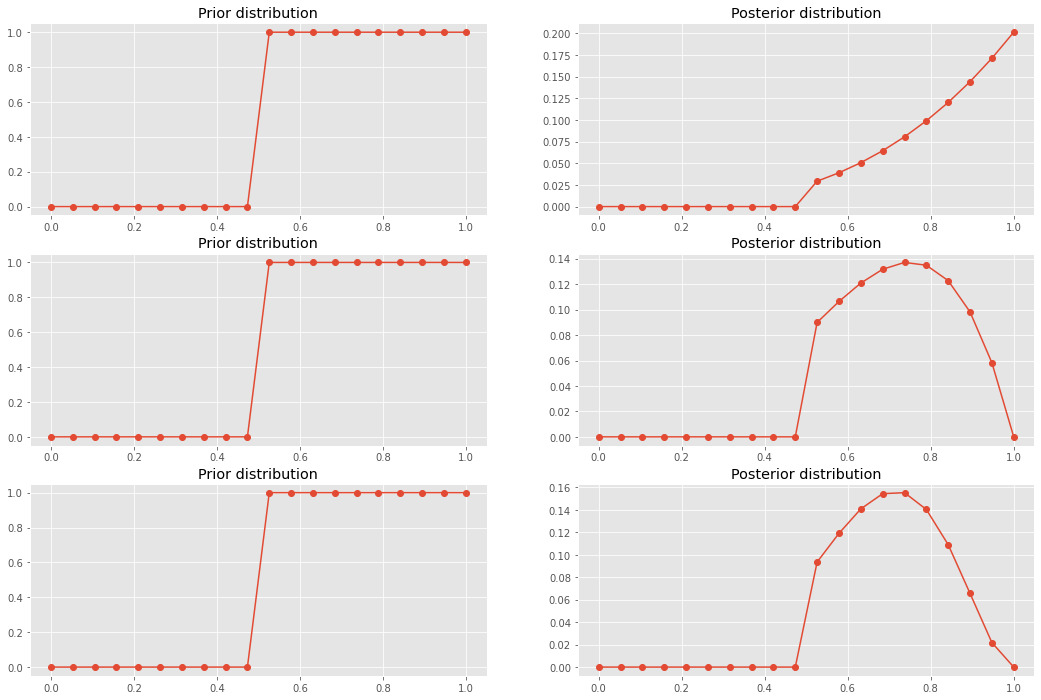

In [47]:
priorfn = lambda grid: np.where(grid >= 0.5, 1, 0)
WL = [(3,3), (3,4), (5,7)]
results = []
for idx, result in enumerate(WL):
    lhfn = lambda grid: stats.binom.pmf(result[0], result[1], grid)
    grid, prior, posterior = grid_approx(priorfn, lhfn, 20)
    results.append((idx, grid, prior, posterior))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for idx, r in enumerate(results):    
    ax[idx, 0].set_title('Prior distribution')
    ax[idx, 0].plot(r[1], r[2], '-o')
    ax[idx, 1].set_title('Posterior distribution')
    ax[idx, 1].plot(r[1], r[3], '-o')

**2M3**. Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered
in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know
which—was tossed in the air and produced a “land” observation. Assume that each globe was equally
likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on
seeing “land” (Pr(Earth|land)), is 0.23.

In [15]:
%watermark -n -u -v -iv -w]

Last updated: Sat Nov 28 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

pymc3     : 3.9.3
numpy     : 1.19.1
arviz     : 0.10.0
scipy     : 1.5.2
matplotlib: 3.3.1
seaborn   : 0.10.1

Watermark: 2.1.0

